# Part 1: Exploratory Data Analysis

In [3]:
#import necessary packages before analyzing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('ggplot')

#load the dataset
logins = pd.read_json("logins.json")

In [4]:
#Take a quick look at the dataset
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
#Get a summary of the dataset
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [6]:
#Get the type of data for each column of the dataset
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [7]:
#Create groups based on login_time with interval of 15 mins
groups = logins.groupby(pd.Grouper(key='login_time', freq='15min'))

In [8]:
#Convert from pandas group object to a list of groups
groups_logins = list(groups)

In [9]:
#generate a dictionary which has the time_interval as key and login_times as values
logins_counts = {}
for i in range(len(groups_logins)):
    count = len(groups_logins[i][1])
    logins_counts[str(groups_logins[i][0])] = count

In [10]:
#create a dataframe from the dictionary generated above
logins_counts_df = pd.DataFrame.from_dict(logins_counts, orient='index', columns=['login_counts'])

In [11]:
#convert the time_interval index from string to datetime object
logins_counts_df.index = pd.to_datetime(logins_counts_df.index)
logins_counts_df.head()

,login_counts
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


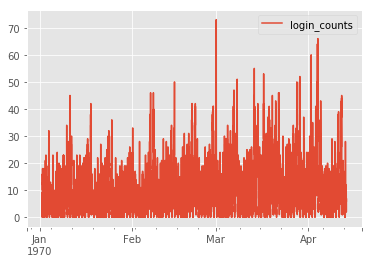

In [12]:
#Generate plot of the login_counts data 
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

logins_counts_df.plot()

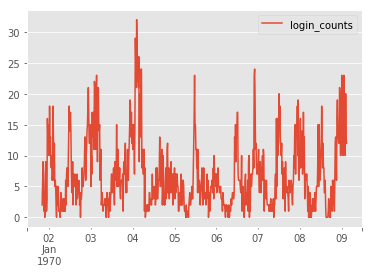

In [13]:
#Zoom in to get a sense of the data in the first month
logins_counts_df[:700].plot()

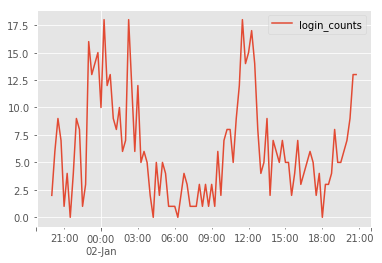

In [14]:
#Zoom in even more to see invidual day
logins_counts_df[:100].plot()

In [15]:

logins_counts_df.max()

login_counts    73
dtype: int64

In [16]:
logins_counts_df[logins_counts_df.login_counts == 73].index[0].dayofweek

6

In the graph above, it shows  that there is a high-peak versus low-peak trend present within this dataset. There seems to be a high-peak and low-peak time for each day and the interval seems to be 12 hours (early morning and early afternoon). The maximum peak is in the month of April and it is a Sunday. Now in order to test if Sunday always has the high peak for each week, we will have to find the max peak for each week. In order to accomplish this, we will divide the length of the logins_counts_df by 96 (24 hours/day => 1440 mins/day => 96 data points/day for 15 min inverval) and then divide by 7 to get the week counts. 

In [17]:
# Get number of weeks from the data set
len(logins_counts_df)/96/7

14.56547619047619

In [18]:
max_day_of_week = {}
for i in range(14):
    max_peak = logins_counts_df[i*96*7:(i+1)*96*7].login_counts.max()
    day_of_week = logins_counts_df[logins_counts_df.login_counts == max_peak].index[0].dayofweek
    login_interval = logins_counts_df[logins_counts_df.login_counts == max_peak].index[0]
    max_day_of_week[login_interval] = day_of_week

max_day_of_week_df = pd.DataFrame.from_dict(max_day_of_week, orient='index', columns=['day_of_week'])

max_day_of_week_df.groupby(by='day_of_week').size()

day_of_week
2    1
4    1
5    2
6    8
dtype: int64

It appears that there are 8 weeks that have Sunday as the highest peak, 2 weeks that have Saturday as the highest peak day, 1 week that has Thursday as the high-peak day and 1 week that has Wednesday as the highest-peak day. Overall, this trend tells us that the weekends are commonly the highest-peak days. 

# Part 2: Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. 

However a toll bridge , with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partnerrs to be available in both cities, by reimbursing all toll costs. 

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

    I would choose weekend engagement for drivers in both cities as the key measure of success of this experiment. I choose this metric since there is a high-peak and low-peak activities during the weekdays (as we have seen above) during a twelve-hour period, it would be less likely that the drivers would want to work for more than 12 hours in order to take the advantage of both cities. However, there is a reasonable activiy in both cities during the weekends and thus it is more than likely they will try to drive back and forth between the two cities without paying for the tolls. 
  
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    * How you will implement the experiment 
    * What statistical test(s) you will conduct to verify the significance of the observation 
    * How you would interpret the results and provide recommendations to the city operations team along with any caveats
    
    First, I would track the drivers' activity during the weekends in both cities before implementing any changes to the city policy. After I get the initial dataset of the activities of all drivers in the cities, an annoucement would then be made to all drivers that the tolls will be reimbursed as they take the bridge between the two cities. After that, I will then monitor their activities in both cities during the weekends. For the intitial dataset (before an annoucement was made), I would make the comparison to determine which city they tend to serve, if there is any, during weekends. This task would give me a ratio of the number of trips in one city versus the number of trips in another city. I then do a two-tailed t-test to compare the number of trips back and forth between the two cities during the weekends before and after the policy has been changed. In order to conduct a t-test, I would need to set out a statistical significance. If the p-value of the two-tailed t-test turns out to be greater than the level of significance, then there is no difference before and after the policy change. However, the p-value is less than the significance level then I would recommend the policy to be changed permanently. 

# Part 3: Predictive Modeling 

## Explore the Rention Rate of Drivers

In [19]:
import json

with open('ultimate_data_challenge.json') as f:
    ultimate_data = json.load(f)

ultimate_data = pd.DataFrame(ultimate_data)

In [20]:
ultimate_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [21]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
ultimate_data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In order to calculate the retention rate, we must know whether the last_trip_date falls within the 30 days of (let's say) the 6 month period after they signed up. Since I don't know the time that the data was pulled out, I would just assume 6 months from the signup date to be the timeframe. 

In [23]:
ultimate_data.last_trip_date = pd.to_datetime(ultimate_data.last_trip_date)
ultimate_data.signup_date = pd.to_datetime(ultimate_data.signup_date)
ultimate_data['six_months_from_signup'] = ultimate_data.signup_date + pd.Timedelta('181D')
ultimate_data['date_from_last'] = ultimate_data['six_months_from_signup'] - pd.Timedelta('30D')
ultimate_data['active'] = (ultimate_data['last_trip_date'] >= ultimate_data['date_from_last'])

In [24]:
ultimate_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,six_months_from_signup,date_from_last,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,2014-07-25,2014-06-25,False
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2014-07-29,2014-06-29,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,2014-07-06,2014-06-06,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2014-07-10,2014-06-10,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,2014-07-27,2014-06-27,False


In [25]:
retention_rate = 100*len(ultimate_data[ultimate_data['active'] == True]) / len(ultimate_data)

In [26]:
print ('The retention rate is ', retention_rate)

The retention rate is  24.396


## Build a Predictive Model

In [27]:
#Before building any predictive model, let convert all the boolean columns into 0 for False and 1 for True
ultimate_data['active'] = ultimate_data['active']*1

In [28]:
ultimate_data['ultimate_black_user'] = ultimate_data['ultimate_black_user']*1

In [29]:
#Now let's only look at the numeric data portion of the dataset
ultimate_numeric_data = ultimate_data._get_numeric_data()
ultimate_numeric_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,0
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0


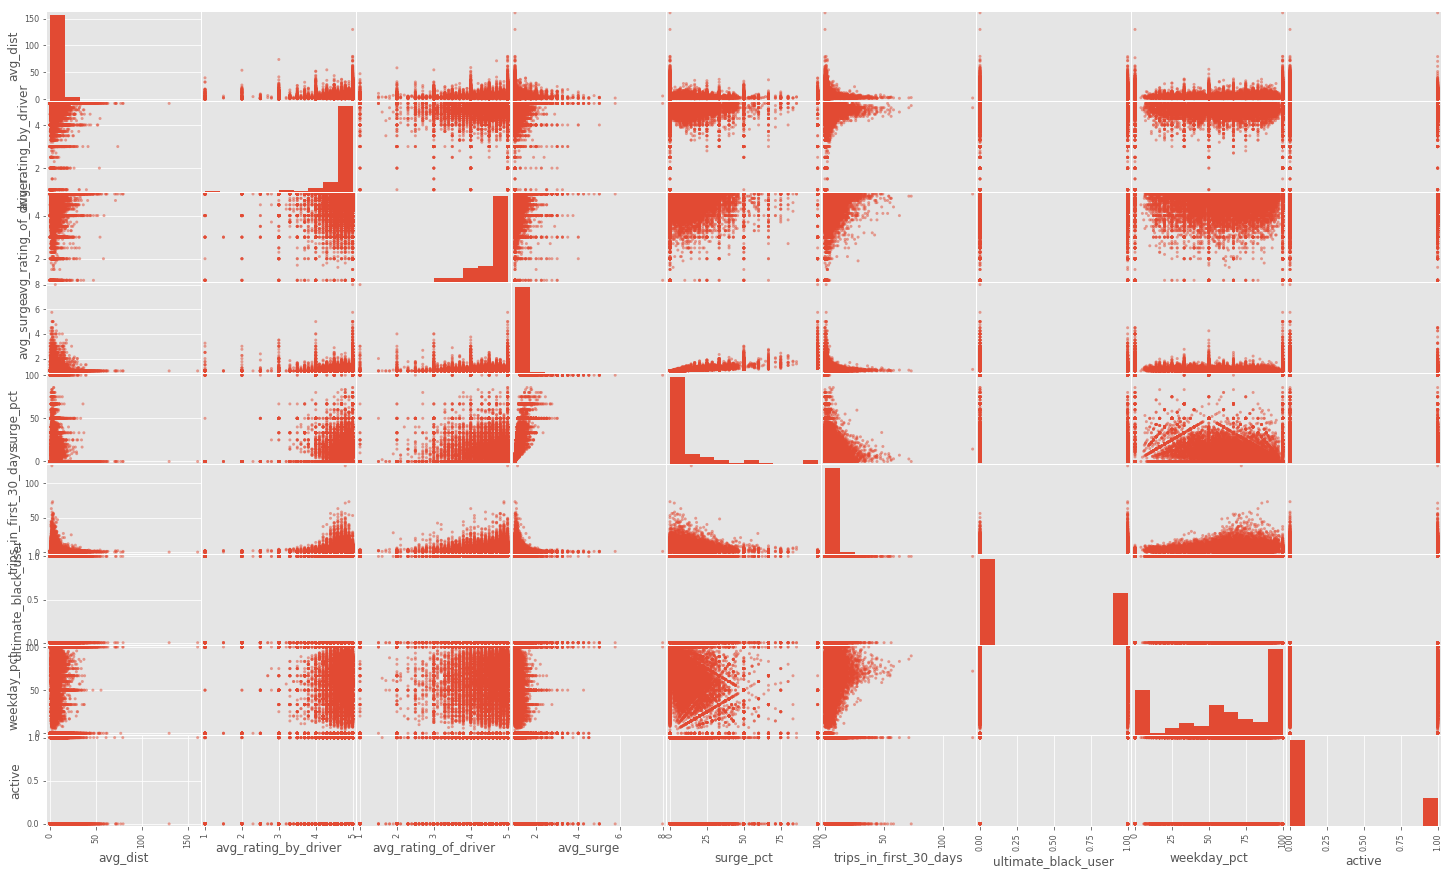

In [34]:
#Let's now take a look at the correlation between 2 different variables, including the 'target' variable
from pandas.plotting import scatter_matrix

scatter_matrix(ultimate_numeric_data, figsize=(25, 15))
plt.show()

Based in on the matrix plot above, none of the variables is very strongly correalated to another one so that means we can include all features into our predictive model if necessary. However, we should also include the categorical columns into the predictive model. For example, if the user experience on iphone is very bad in comparison to those using Android then this could absolutely affect the retention rate. Now, in order to include the categorical data into our model, we have to encode them using LabelEncoder.

In [73]:
#transfrom cateogorical columns into numerical columns using sklearn.preprocessing
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
le.fit(ultimate_data.city.unique())
ultimate_data.city = le.transform(ultimate_data.city)
LE = preprocessing.LabelEncoder()
LE.fit(ultimate_data.phone.dropna().unique())
ultimate_data.phone = LE.transform(ultimate_data.phone)

In [74]:
#Make sure there is no none data point
ultimate_data = ultimate_data.dropna()

In [75]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 15 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null int64
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null int64
signup_date               41445 non-null datetime64[ns]
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null int64
weekday_pct               41445 non-null float64
six_months_from_signup    41445 non-null datetime64[ns]
date_from_last            41445 non-null datetime64[ns]
active                    41445 non-null int64
dtypes: datetime64[ns](4), float64(6), int64(5)
memory usage: 5.1 MB


In [76]:
#recheck retention rate after dropping na to make sure this is the right method to deal with NA values
retention_rate = 100*len(ultimate_data[ultimate_data['active'] == True]) / len(ultimate_data)
print ('The retention rate is ', retention_rate)

The retention rate is  27.1106285438533


The retention rate changes from 24.4% to 27.1%, which is not that significant and thus I decided to just drop the NA values and move on with my analysis and model selection process. 

In [77]:
#Splitting features versus target
X = ultimate_data.drop(['active', 'last_trip_date', 'signup_date', 'date_from_last', 'six_months_from_signup'], axis=1)
y = ultimate_data.active

Since the problem we are having here is to predict whether an indivial driver will stay after 6 months with Ultimate, this is a binary outcome;  I choose to use logistic regression method for my model. 

In [117]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Splitting the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

#Create a Logistic Regression classifier
lg = LogisticRegression()

#Fit the classifier to the training data
lg.fit(X_train, y_train)

#Predict the labels for the test set:
y_pred = lg.predict(X_test)

#evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('The accuracy score is ', accuracy_score(y_test, y_pred)*100)

[[5829  178]
 [1997  285]]
             precision    recall  f1-score   support

          0       0.74      0.97      0.84      6007
          1       0.62      0.12      0.21      2282

avg / total       0.71      0.74      0.67      8289

The accuracy score is  73.76040535649656


In [115]:
#Lets observe the feature importance 
lg_feature_importance = pd.DataFrame(np.transpose(lg.coef_), index=X.columns, columns=['feature_importance']).reset_index()
lg_feature_importance.columns = ['feature_name', 'feature_importance']
lg_feature_importance

,feature_name,feature_importance
0,avg_dist,-0.038411
1,avg_rating_by_driver,-0.089753
2,avg_rating_of_driver,0.019618
3,avg_surge,-0.439530
4,city,0.179147
5,phone,0.970936
6,surge_pct,0.007060
7,trips_in_first_30_days,0.083863
8,ultimate_black_user,0.699185
9,weekday_pct,-0.000044


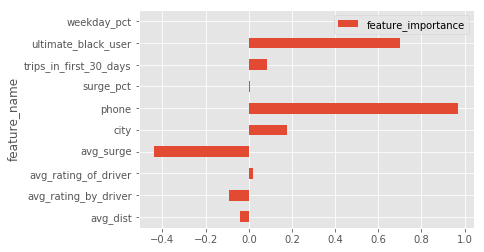

In [113]:
lg_feature_importance.plot(kind='barh', x ='feature_name')

It is very interesting to see that the phone, ultimate_black_user, avg_surge, trip_in_first_30_days and city have a large importance to the logistic model. This fact implies that we could drop the other features in our process of building the logistic model for this kind of problem. The overvall accuracy score for this model is 73.8% with the confusion matrix shown above. However, we can further tune the model by optimzing the hypermeter using a GridSearch as way to cross_validate

In [146]:
#Set up a hyperparameter grid 
c_space = np.logspace(-20,8,20)
param_grid = {'C': c_space}

from sklearn.model_selection import GridSearchCV

lg_cv = GridSearchCV(lg, param_grid, cv=5)
lg_cv.fit(X_train, y_train)

y_cv_pred = lg_cv.predict(X_test)
print ("Tuned logistic regression parameters: {}".format(lg_cv.best_params_))
print ('Best score is {}'.format(lg_cv.best_score_))

Tuned logistic regression parameters: {'C': 0.14384498882876542}
Best score is 0.7442695138134877


In [142]:
#Tuning the hyperparameter helps to increase the accuracy score from 73.7 to 74.4, which is not that much
# so let's now drop a few features that are not as important from the X features list

X_new = X.drop(['surge_pct', 'avg_rating_of_driver', 'avg_rating_by_driver', 'avg_dist'], axis=1)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.2, random_state=1234)

In [147]:
lg_new = LogisticRegression()
lg_new.fit(X_new_train, y_new_train)
y_new_pred = lg_new.predict(X_new_test)

print ('The new accuracy score after dropping some features is {}'.format(accuracy_score(y_new_pred, y_new_test)))

The new accuracy score after dropping some features is 0.7366389190493425


By dropping the number of features being used to build the logistic regression model for this dataset, I was able to obtain a 73.7% accuracy in predicting the labels for the users.  

### Conclusion

Using the provided dataset by Ultimate, I was able to establish a binary logistic regression model which could help predicting whether an invidial driver will be inactive in 6 months. In order to build this model, I first look at the correlation between two differetn numerical variables to determine whether there is intercorrelation exist. I then included categorical variables into the model by converting them into one-hot-encoding labels. One thing to be noted here is that I calculated the retention rate, percentage of active users, based on the assumption that the data was pulled out 6 months after Jan 2014. However, this assumption could be biased and therefore potentially affecting the prediction of the user status (active or not active). Because of this, a more precise time of when the data was collected is very necessary to correctly lable the status of the user. 

The model that I build could help pointing out the fact the mobile app is very important and could affect the user experience a lot, which indirectly affects the user retention rate. Another important fact that Ultimate can also gain from this model is the importance of city feature. It would be very beneficial to compare the active users among cities and determine if there is any difference and why. 